In [5]:
from datetime import datetime
import pandas as pd
import ast
import numpy as np
import itertools
import seaborn as sns
from pandas.api.types import CategoricalDtype
import matplotlib

In [2]:
file_users = "/Users/kadir/github-data/Users.csv"
file_watcher = "/Users/kadir/github-data/Watchers.csv"
file_repos = "/Users/kadir/github-data/Repos.csv"
file_commits = "/Users/kadir/github-data/Commits.csv"

df_users = pd.read_csv(file_users, low_memory=False, na_filter=False,na_values=0)

df_repos = pd.read_csv(file_repos, low_memory=False, na_filter=False,na_values=0)
df_repos['language'] = df_repos['language'].astype(str)
df_repos['language'] = df_repos['language'].str.lower()
df_repos['language'].replace('', np.nan, inplace=True)

df_watched_repos = pd.read_csv(file_watcher, low_memory=False, na_filter=False, na_values=0)

df_commits = pd.read_csv(file_commits, low_memory=False, na_filter=False, na_values=0)


In [5]:
combinations = list(itertools.product(df_repos.repo_id.sort_values(),df_users.id.sort_values()))
df_all_user_repo = pd.DataFrame(data=combinations, columns = ['repo_id', 'user_id'])
df_all_user_repo.head()

,repo_id,user_id
0,1,21
1,1,25
2,1,38
3,1,108
4,1,173


In [6]:
ownership = df_repos[['repo_id','owner_id']]
x = pd.merge(df_all_user_repo, ownership, how="left", on=['repo_id'])
x['is_ownered'] = np.where((x['user_id'] == x['owner_id']),1,0)
x.head()

,repo_id,user_id,owner_id,is_ownered
0,1,21,1,0
1,1,25,1,0
2,1,38,1,0
3,1,108,1,0
4,1,173,1,0


In [7]:
def toplanguages(languages):
    languages = [x.lower() for x in languages]
    unique, counts = np.unique(languages, return_counts=True)
    languages_counts = dict(zip(unique, counts))
    x = {k: v for k, v in sorted(languages_counts.items(), key=lambda item: item[1],reverse=True)}
    toplanguages = list(x.keys())
    countlang = len(toplanguages)
    if countlang >= 3:
        bestLanguages = toplanguages[0:3]
    else:
        bestLanguages = toplanguages
    return bestLanguages

In [8]:
repos_lang_owned = df_repos[df_repos['owner_id'].isin(list(df_users.id))][['repo_id','owner_id','language']]
repos_lang_owned = repos_lang_owned.sort_values("owner_id")
repos_lang_owned.dropna(subset=['language'],inplace = True)
mydict = repos_lang_owned.groupby('owner_id').apply(lambda x: x['language'].tolist()).to_dict()
top_lang_owner = pd.Series(mydict).reset_index()
top_lang_owner.columns = ['user_id', 'languages']
top_lang_owner['top_lang_owned'] = top_lang_owner.languages.apply(toplanguages)
top_lang_owner.head()

,user_id,languages,top_lang_owned
0,21,"[c, ruby, ruby, ruby, go, ruby, ruby, go, ruby...","[ruby, javascript, go]"
1,25,"[javascript, ruby, javascript, javascript, rub...","[javascript, ruby, coffeescript]"
2,38,"[ruby, javascript, javascript, coffeescript, c...","[ruby, javascript, coffeescript]"
3,108,"[ruby, shell, ruby, ruby, ruby, css, css, go, ...","[ruby, shell, go]"
4,173,"[javascript, ruby, ruby, javascript, ruby, rub...","[ruby, javascript, shell]"


In [9]:
df_commitsx = pd.merge(df_commits,df_repos[['repo_id','language']],how="left", on=['repo_id'])
repos_lang_committed = df_commitsx[df_commitsx['committer_id'].isin(list(df_users.id))][['repo_id','committer_id','language']]
repos_lang_committed = repos_lang_committed.sort_values("committer_id")
repos_lang_committed.dropna(subset=['language'],inplace = True)
mydict = repos_lang_committed.groupby('committer_id').apply(lambda x: x['language'].tolist()).to_dict()
top_lang_committer = pd.Series(mydict).reset_index()
top_lang_committer.columns = ['user_id', 'languages']
top_lang_committer['top_lang_committed'] = top_lang_committer.languages.apply(toplanguages)
top_lang_committer.head()

,user_id,languages,top_lang_committed
0,21,"[go, go, go, go, go, go, go, go, go, go, go, g...","[go, ruby]"
1,25,"[ruby, ruby, ruby, ruby, ruby, ruby, css, ruby...","[ruby, coffeescript, css]"
2,38,"[ruby, ruby, ruby, ruby, ruby, coffeescript, r...","[ruby, coffeescript]"
3,108,"[ruby, html, ruby, ruby]","[ruby, html]"
4,173,"[ruby, ruby, css, ruby, ruby, ruby, ruby, coff...","[ruby, css, coffeescript]"


In [10]:
df_watched_reposx = pd.merge(df_watched_repos,df_repos[['repo_id','language']],how="left", on=['repo_id'])
repos_lang_watched = df_watched_reposx[df_watched_reposx['user_id'].isin(list(df_users.id))][['repo_id','user_id','language']]
repos_lang_watched = repos_lang_watched.sort_values("user_id")
repos_lang_watched.dropna(subset=['language'],inplace = True)
mydict = repos_lang_watched.groupby('user_id').apply(lambda x: x['language'].tolist()).to_dict()
top_lang_watcher = pd.Series(mydict).reset_index()
top_lang_watcher.columns = ['user_id', 'languages']
top_lang_watcher['top_lang_watched'] = top_lang_watcher.languages.apply(toplanguages)
top_lang_watcher.head()

,user_id,languages,top_lang_watched
0,21,"[ruby, ruby, javascript, go, javascript, c++, ...","[ruby, javascript, go]"
1,25,"[objective-c, ruby, javascript, ruby, javascri...","[javascript, ruby, objective-c]"
2,38,"[ruby, ruby, javascript, ruby, ruby, ruby, rub...","[ruby, javascript, go]"
3,108,"[ruby, go, javascript, ruby, javascript, go, r...","[ruby, javascript, go]"
4,173,"[ruby, javascript, ruby, coffeescript, javascr...","[ruby, javascript, css]"


In [11]:
temp = pd.merge(top_lang_owner[['user_id','languages']],
                              top_lang_committer[['user_id','languages']],
                              how="left", on=['user_id'])
temp = pd.merge(temp,
                top_lang_watcher[['user_id','languages']],how="left", on=['user_id'])
temp['langs'] = temp.iloc[:,[1,2,3]].stack().groupby(level=0).sum()
all_langs = temp.loc[:,['user_id','langs']]
all_langs.rename(columns={'langs': 'languages'}, inplace=True)
all_langs['top_lang_all'] = all_langs.languages.apply(toplanguages)
all_langs

,user_id,languages,top_lang_all
0,21,"[c, ruby, ruby, ruby, go, ruby, ruby, go, ruby...","[go, ruby, javascript]"
1,25,"[javascript, ruby, javascript, javascript, rub...","[javascript, ruby, objective-c]"
2,38,"[ruby, javascript, javascript, coffeescript, c...","[ruby, javascript, coffeescript]"
3,108,"[ruby, shell, ruby, ruby, ruby, css, css, go, ...","[ruby, javascript, shell]"
4,173,"[javascript, ruby, ruby, javascript, ruby, rub...","[ruby, javascript, css]"
...,...,...,...
95,3346407,"[css, python, python, lua, c++, python, python...","[python, javascript, css]"
96,3451712,"[javascript, javascript, javascript, css, java...","[javascript, css, ruby]"
97,4323180,"[php, php, python, php, php, php, php, php, ph...","[php, css, ruby]"
98,4921183,"[javascript, javascript, javascript, javascrip...","[javascript, css, php]"


In [23]:
all_langs.head(20)

,user_id,languages,top_lang_all
0,21,"[c, ruby, ruby, ruby, go, ruby, ruby, go, ruby...","[go, ruby, javascript]"
1,25,"[javascript, ruby, javascript, javascript, rub...","[javascript, ruby, objective-c]"
2,38,"[ruby, javascript, javascript, coffeescript, c...","[ruby, javascript, coffeescript]"
3,108,"[ruby, shell, ruby, ruby, ruby, css, css, go, ...","[ruby, javascript, shell]"
4,173,"[javascript, ruby, ruby, javascript, ruby, rub...","[ruby, javascript, css]"
5,990,"[javascript, css, javascript, javascript, java...","[javascript, ruby, c]"
6,1060,"[ruby, ruby, ruby, javascript, javascript, jav...","[ruby, javascript, coffeescript]"
7,1299,"[viml, shell, go, go, shell, shell, go, go, ru...","[ruby, go, python]"
8,1377,"[javascript, javascript, javascript, javascrip...","[javascript, ruby, shell]"
9,2567,"[ruby, c, python, ruby, c, ruby, python, javas...","[ruby, c, javascript]"


In [12]:
temp = pd.merge(top_lang_owner[['user_id','top_lang_owned']],
                              top_lang_committer[['user_id','top_lang_committed']],
                              how="left", on=['user_id'])
temp = pd.merge(temp,
                top_lang_watcher[['user_id','top_lang_watched']],
                how="left", on=['user_id'])
df_users_topLangs = pd.merge(temp,
                              all_langs[['user_id','top_lang_all']],
                              how="left", on=['user_id'])


In [81]:
df_users_topLangs

,user_id,top_lang_owned,top_lang_committed,top_lang_watched,top_lang_all
0,21,"[ruby, javascript, go]","[go, ruby]","[ruby, javascript, go]","[go, ruby, javascript]"
1,25,"[javascript, ruby, coffeescript]","[ruby, coffeescript, css]","[javascript, ruby, objective-c]","[javascript, ruby, objective-c]"
2,38,"[ruby, javascript, coffeescript]","[ruby, coffeescript]","[ruby, javascript, go]","[ruby, javascript, coffeescript]"
3,108,"[ruby, shell, go]","[ruby, html]","[ruby, javascript, go]","[ruby, javascript, shell]"
4,173,"[ruby, javascript, shell]","[ruby, css, coffeescript]","[ruby, javascript, css]","[ruby, javascript, css]"
...,...,...,...,...,...
95,3346407,"[python, javascript, css]","[css, python, viml]","[python, javascript, go]","[python, javascript, css]"
96,3451712,"[css, javascript, ruby]","[javascript, css]","[javascript, css, ruby]","[javascript, css, ruby]"
97,4323180,"[php, css, javascript]","[php, css]","[php, ruby, css]","[php, css, ruby]"
98,4921183,"[javascript, php, css]","[css, javascript]","[javascript, php, python]","[javascript, css, php]"


In [82]:
export_csv = df_users_topLangs.to_csv (r'/Users/kadir/Desktop/topLanguages.csv',index=False, header=True)

In [2]:
file_repos = "/Users/kadir/github-data/Repos.csv"

df_repos = pd.read_csv(file_repos, low_memory=False, na_filter=False,na_values=0)
df_repos['language'] = df_repos['language'].astype(str)
df_repos['language'] = df_repos['language'].str.lower()
df_repos['language'].replace('', np.nan, inplace=True)


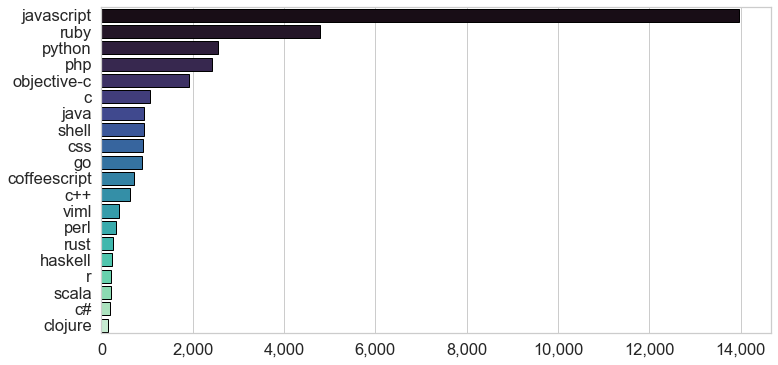

In [8]:
sns.set(style="whitegrid", font_scale=1.5,rc={'figure.figsize':(12,6)})
sns.color_palette("rocket")
df = df_repos.loc[:,['repo_id','language']]
fig= sns.countplot(y=df.language, 
                    data=df,
                    order=df.language.value_counts().iloc[:20].index,
                    edgecolor=(0,0,0),
                    linewidth=1,
                    saturation=1,
                    palette="mako"
                   )
fig.set_xlabel('', fontweight='bold')
fig.set_ylabel('', fontweight='bold')
fig.get_xaxis().set_major_formatter(
matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.figure.savefig('languages.png',dpi=600)